# 1. Used Libraries

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings("ignore")
import pickle
sns.set_style("dark")
plt.rcParams["figure.figsize"] = (5, 7)
%matplotlib inline

# 2. Data Ingestion

In [6]:
df = pd.read_csv(r"W:\Development\Graduation Project\Disease datasets\new_datasets\extended_diabetes.csv", encoding="utf-8")
print("Original Dataset shape:", df.shape)

Original Dataset shape: (1536, 8)


# 3. Exploring The Data & Cleaning

In [11]:
print("First 3 rows:")
print(df.head(3))

First 3 rows:
   Glucose  BloodPressure  Insulin   BMI  DiabetesPedigreeFunction  HB A1C  \
0    148.0           72.0      0.0  33.6                     0.627    7.44   
1     85.0           66.0      0.0  26.6                     0.351    5.40   
2    183.0           64.0      0.0  23.3                     0.672    8.33   

    Age  Outcome  
0  50.0        1  
1  31.0        0  
2  32.0        1  


print("Last 3 rows:")
print(df.tail(3))

#### 4. Check For Entries & Data Types


In [16]:
print("Data Types and non-null counts:")
print(df.info())

Data Types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1536 entries, 0 to 1535
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Glucose                   1536 non-null   float64
 1   BloodPressure             1536 non-null   float64
 2   Insulin                   1536 non-null   float64
 3   BMI                       1536 non-null   float64
 4   DiabetesPedigreeFunction  1536 non-null   float64
 5   HB A1C                    1536 non-null   float64
 6   Age                       1536 non-null   float64
 7   Outcome                   1536 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 96.1 KB
None


#### 5. Statistics About Dataset


In [22]:
print("Descriptive statistics:")
print(df.describe())


Descriptive statistics:
           Glucose  BloodPressure      Insulin          BMI  \
count  1536.000000    1536.000000  1536.000000  1536.000000   
mean    110.841387      64.803438   251.351979    32.997878   
std      46.757844      28.819466   258.417175    14.835451   
min       0.000000       0.000000     0.000000     0.000000   
25%      84.000000      50.667500     9.832500    24.600000   
50%     112.000000      70.000000   154.595000    32.500000   
75%     143.225000      83.602500   446.992500    40.855000   
max     199.000000     122.000000   846.000000    67.100000   

       DiabetesPedigreeFunction       HB A1C          Age      Outcome  
count               1536.000000  1536.000000  1536.000000  1536.000000  
mean                   0.770606     6.151522    42.223398     0.319010  
std                    0.547622     1.237218    17.379950     0.466245  
min                    0.078000     4.510000    21.000000     0.000000  
25%                    0.304000     5.09000

#### 6. Visualize Features To Check Distribution (Numeric features)


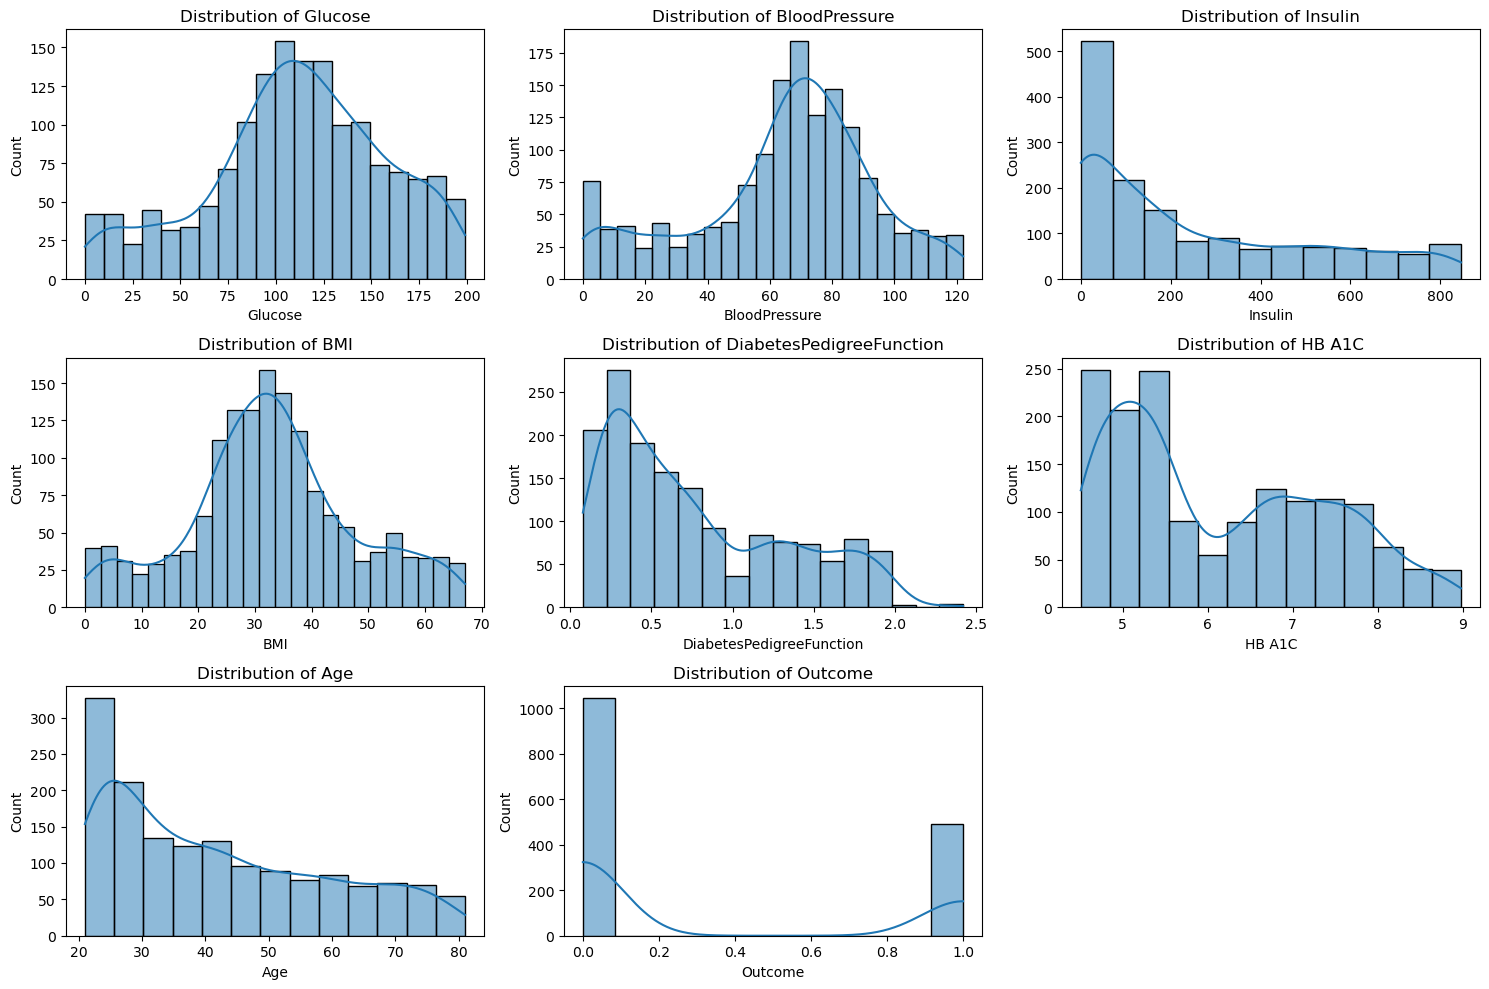

In [29]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
#print("Numeric columns:", numeric_cols)

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot((len(numeric_cols)+2)//3, 3, i+1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

#### 7. Check Categorical Features Values Distribution (if exists)


In [36]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", categorical_cols)

if len(categorical_cols) > 0:
    plt.figure(figsize=(15, 5*len(categorical_cols)))
    for i, col in enumerate(categorical_cols):
        plt.subplot(len(categorical_cols), 1, i+1)
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.title(f'Counts of {col}')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No categorical features found.")

Categorical columns: []
No categorical features found.


#### 8. Check Target Classes Balance
##### Assuming target column is 'Outcome'

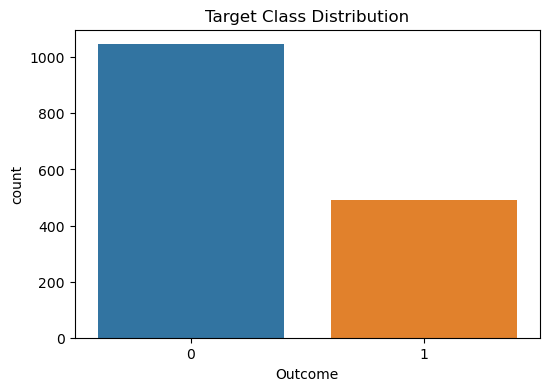

In [39]:
target = 'Outcome'
if target in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=target, order=df[target].value_counts().index)
    plt.title('Target Class Distribution')
    plt.show()
else:
    print(f"Target column '{target}' not found.")

#### 9. Checking For Missing Values


In [42]:
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])


Missing values per column:
Series([], dtype: int64)


#### 10. Checking For Duplication


In [47]:
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)
if duplicates > 0:
    df = df.drop_duplicates()
    print("Duplicates dropped. New shape:", df.shape)

Number of duplicate rows: 0


#### 11. Data Preparation & Preprocessing For ML
##### Encode categorical variables if they exist

In [52]:
if len(categorical_cols) > 0:
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    print("Categorical features encoded.")


##### 11.1 - Visualize Numeric Features Correlation


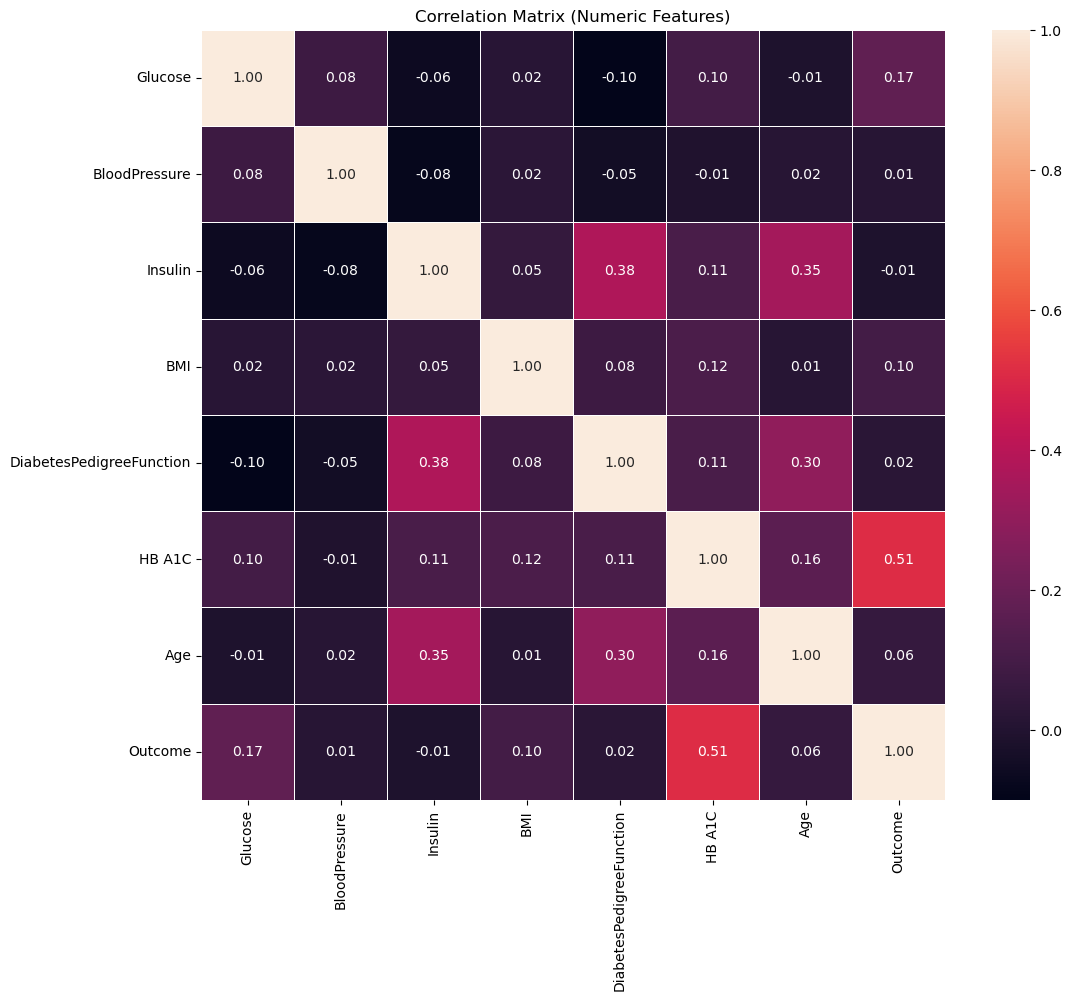

In [57]:
plt.figure(figsize=(12, 10))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot = True, fmt = '0.2f', linewidths = 0.5)
plt.title("Correlation Matrix (Numeric Features)")
plt.show()


**NOTE**</br>
From Features Correlations,</br>
It means features are independent and contribute unique information to the model.

##### 11.2 - Data Separation: Split features and target


In [61]:
if target not in df.columns:
    raise ValueError(f"Target column '{target}' is not in the dataset.")
X = df.drop(columns=[target])
y = df[target]


#### Additional Feature Engineering: Outlier Removal
##### Use a less aggressive IQR multiplier (2.0 instead of 1.5)

In [64]:
data_combined = pd.concat([X, y], axis=1)
for col in numeric_cols:
    Q1 = data_combined[col].quantile(0.25)
    Q3 = data_combined[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2.0 * IQR
    upper_bound = Q3 + 2.0 * IQR
    data_combined = data_combined[(data_combined[col] >= lower_bound) & (data_combined[col] <= upper_bound)]
print("Data shape after outlier removal:", data_combined.shape)

Data shape after outlier removal: (1536, 8)


##### Update X and y after outlier removal


In [67]:
X = data_combined.drop(columns=[target])
y = data_combined[target]

#### 12. Training, Validation, and Testing Construction
##### Split the dataset: 64% train, 20% test , 16% validation 

In [70]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (982, 7)
Validation shape: (246, 7)
Test shape: (308, 7)


##### 13. Final Scaling using RobustScaler (robust against outliers)


In [74]:
robust_scaler = RobustScaler()
X_train_scaled = robust_scaler.fit_transform(X_train)
X_val_scaled = robust_scaler.transform(X_val)
X_test_scaled = robust_scaler.transform(X_test)
joblib.dump(robust_scaler, 'robust_scaler.pkl')

['robust_scaler.pkl']

##### 14. Address Class Imbalance using SMOTE on the training set


In [77]:
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_scaled, y_train)
print("Class distribution after SMOTE:", np.bincount(y_train_bal))


Class distribution after SMOTE: [669 669]


#### 15. Model Building using Three Different Models

In [80]:
# --- Model 1: Logistic Regression ---
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_bal, y_train_bal)
y_val_pred_lr = lr.predict(X_val_scaled)
acc_lr = accuracy_score(y_val, y_val_pred_lr)
print("Logistic Regression Validation Accuracy:", acc_lr)

Logistic Regression Validation Accuracy: 0.7967479674796748


In [82]:
# --- Model 2: Random Forest Classifier ---
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_bal, y_train_bal)
y_val_pred_rf = rf.predict(X_val_scaled)
acc_rf = accuracy_score(y_val, y_val_pred_rf)
print("Random Forest Validation Accuracy:", acc_rf)


Random Forest Validation Accuracy: 0.8211382113821138


In [84]:
# --- Model 3: Support Vector Machine (SVM) ---
svm = SVC(random_state=42)
svm.fit(X_train_bal, y_train_bal)
y_val_pred_svm = svm.predict(X_val_scaled)
acc_svm = accuracy_score(y_val, y_val_pred_svm)
print("SVM Validation Accuracy:", acc_svm)

SVM Validation Accuracy: 0.7764227642276422


#### Compare models based on validation accuracy


In [87]:
model_scores = {'LogisticRegression': acc_lr, 'RandomForest': acc_rf, 'SVM': acc_svm}
best_model_name = max(model_scores, key=model_scores.get)
print("Best model based on validation accuracy:", best_model_name)


Best model based on validation accuracy: RandomForest


#### 16. Hyperparameter Tuning on the Best Model

In [90]:
if best_model_name == 'LogisticRegression':
    model = LogisticRegression(max_iter=1000, random_state=42)
    param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']}
    grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid.fit(X_train_bal, y_train_bal)
    best_model = grid.best_estimator_
    print("Best parameters for Logistic Regression:", grid.best_params_)
elif best_model_name == 'RandomForest':
    model = RandomForestClassifier(random_state=42)
    param_grid = {'n_estimators': [50, 100, 200],
                  'max_depth': [None, 5, 10],
                  'min_samples_split': [2, 5, 10]}
    grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid.fit(X_train_bal, y_train_bal)
    best_model = grid.best_estimator_
    print("Best parameters for Random Forest:", grid.best_params_)
elif best_model_name == 'SVM':
    model = SVC(random_state=42)
    param_grid = [
        {'kernel': ['linear'], 'C': [0.1, 1, 10, 50, 100]},
        {'kernel': ['rbf'], 'C': [0.1, 1, 10, 50, 100], 'gamma': ['scale', 'auto']},
        {'kernel': ['poly'], 'C': [0.1, 1, 10, 50, 100], 'gamma': ['scale', 'auto'], 'degree': [2, 3]}
    ]
    grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid.fit(X_train_bal, y_train_bal)
    best_model = grid.best_estimator_
    print("Best parameters for SVM:", grid.best_params_)


Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


#### Evaluate tuned best model on the validation set


In [93]:
if best_model_name in ['LogisticRegression', 'SVM']:
    y_val_pred_best = best_model.predict(X_val_scaled)
else:
    y_val_pred_best = best_model.predict(X_val_scaled)
print("Tuned Best Model Validation Accuracy:", accuracy_score(y_val, y_val_pred_best))
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred_best))

Tuned Best Model Validation Accuracy: 0.8170731707317073
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       167
           1       0.70      0.75      0.72        79

    accuracy                           0.82       246
   macro avg       0.79      0.80      0.79       246
weighted avg       0.82      0.82      0.82       246



#### 17. Final Evaluation on Unseen Test Data


In [96]:
if best_model_name in ['LogisticRegression', 'SVM']:
    y_test_pred = best_model.predict(X_test_scaled)
else:
    y_test_pred = best_model.predict(X_test_scaled)
print("Test Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

Test Set Accuracy: 0.7597402597402597
Test Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       210
           1       0.65      0.53      0.58        98

    accuracy                           0.76       308
   macro avg       0.72      0.70      0.71       308
weighted avg       0.75      0.76      0.75       308



#### 18. Model Saving


In [ ]:
##joblib.dump(best_model, 'best_diabetes_model.pkl')
##print("Best model saved as 'best_diabetes_model.pkl'")

In [105]:
with open(r"C:\Users\bodyw\GP\gp model\complete_model\diabetes_model.pkl", "wb") as model :
    pickle.dump(best_model, model)